In [57]:
from tensorflow.keras import layers, Model, models
import numpy as np

In [72]:
m = models.Sequential()
m.add(layers.Conv2DTranspose(1, (4, 4), strides=2, activation="linear", padding="valid", input_shape=(250,250,1)))
m.compile(optimizer='adam',loss='binary_crossntropy', metrics=['accuracy'])
m.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_45 (Conv2DT (None, 502, 502, 1)       17        
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [56]:
x = np.array([[1,2],[3,4]]).reshape(1,2,2,1)

In [57]:
x.shape

(1, 2, 2, 1)

In [63]:
print(m(x).numpy().reshape(6,6))

[[-0.760086    0.50689965  0.         -1.520172    1.0137993   0.        ]
 [-0.63644636 -0.46045136  0.         -1.2728927  -0.9209027   0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [-2.280258    1.520699    0.         -3.040344    2.0275986   0.        ]
 [-1.9093391  -1.3813541   0.         -2.5457854  -1.8418055   0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]]


In [62]:
m.get_weights()[0].reshape(2,2)

array([[-0.760086  ,  0.50689965],
       [-0.63644636, -0.46045136]], dtype=float32)

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
# define model
model = Sequential()
# define input shape, output enough activations for for 128 5x5 image
model.add(Dense(128 * 5 * 5, input_dim=100))
# reshape vector of activations into 128 feature maps with 5x5
model.add(Reshape((5, 5, 128)))
# double input from 128 5x5 to 1 10x10 feature map
model.add(Conv2DTranspose(1, (3,3), strides=(1,1), padding='valid'))
# summarize model
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3200)              323200    
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 7, 7, 1)           1153      
Total params: 324,353
Trainable params: 324,353
Non-trainable params: 0
_________________________________________________________________


In [43]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1,L2,l1_l2
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [30]:
seed = 909

## Data imports

In [31]:

image_datagen = ImageDataGenerator(rescale = 1/255)
mask_datagen = ImageDataGenerator(rescale = 1/255)

train_imagegen = image_datagen.flow_from_directory('scan+mask/train/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed)
train_maskgen = mask_datagen.flow_from_directory('scan+mask/train/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed)
val_imagegen = image_datagen.flow_from_directory('scan+mask/val/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed)
val_maskgen = mask_datagen.flow_from_directory('scan+mask/val/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed)
test_imagegen = image_datagen.flow_from_directory('scan+mask/test/scan', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed)
test_maskgen = mask_datagen.flow_from_directory('scan+mask/test/mask', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed)

Found 1838 images belonging to 1 classes.
Found 1838 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.
Found 613 images belonging to 1 classes.


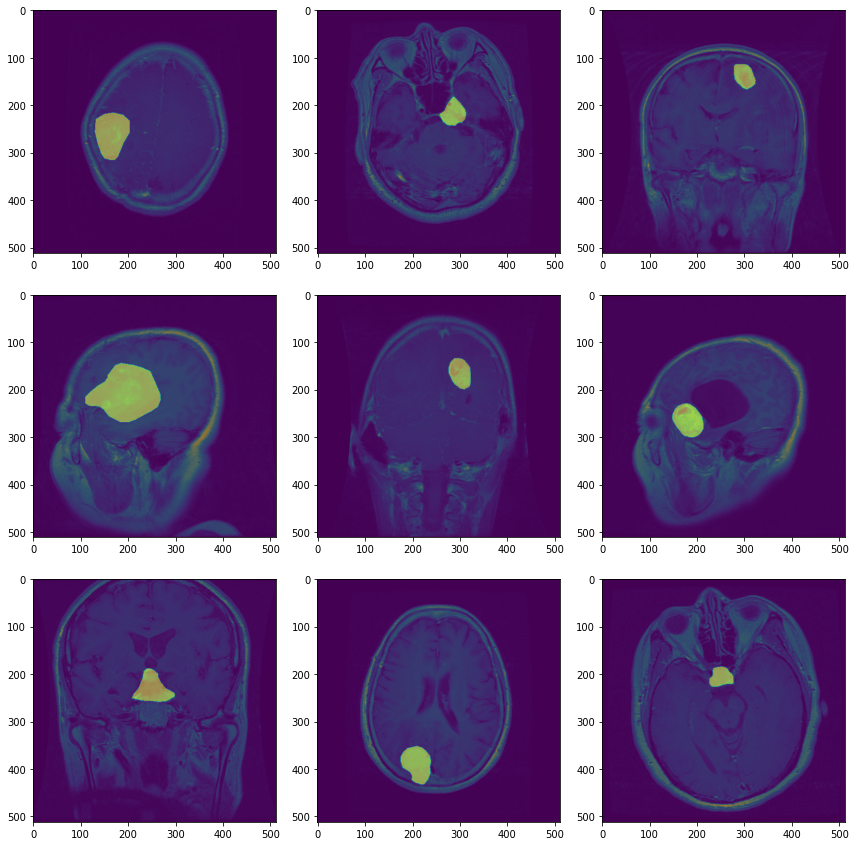

In [41]:
f,ax = plt.subplots(3,3, figsize=(12,12))
plt.tight_layout()
for i,axs in enumerate(ax.ravel()):
    axs.imshow(train_imagegen[i][0], alpha=1)
    axs.imshow(train_maskgen[i][0], alpha=0.5)

plt.show()

## Base Auto-encoder model

In [116]:
filters = [32,32,64,64,128,128]
k_size = [5,5,4,4,3,3]

filters_t = [128,64,32,16,16,1]
k_size_t = [4,4,5,5,5,6,6]

autoenc = models.Sequential()

#encoder
autoenc.add(InputLayer(input_shape = (512,512,1)))

for f,k in zip(filters,k_size): 
    autoenc.add(Conv2D(f, kernel_size = k, strides=(1,1), padding="same", activation='relu'))
    autoenc.add(MaxPooling2D(pool_size=(2,2)))

#decoder
for f,k in zip(filters_t,k_size_t): 
    autoenc.add(Conv2DTranspose(f, kernel_size=k, strides=(2,2), padding="same", activation='relu'))

autoenc.compile(optimizer = Adam(), loss=BinaryCrossentropy(), metrics = ['accuracy'])

In [117]:
autoenc.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_162 (Conv2D)          (None, 512, 512, 32)      832       
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 256, 256, 32)      25632     
_________________________________________________________________
max_pooling2d_157 (MaxPoolin (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 128, 128, 64)      32832     
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 64, 64, 64)      

In [124]:
autoenc.fit(zip(train_imagegen,train_maskgen), epochs=10, batch_size=16, 
            validation_data= zip(val_imagegen, val_maskgen), validation_batch_size=16, workers=-1,
            use_multiprocessing=True)

Epoch 1/10
   4730/Unknown - 1418s 300ms/step - loss: 0.0295 - accuracy: 0.9873

KeyboardInterrupt: 

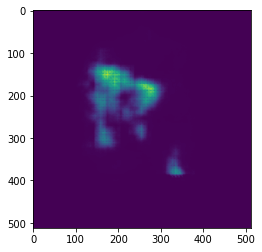

In [125]:
plt.imshow(autoenc.predict(val_imagegen[0])[0])

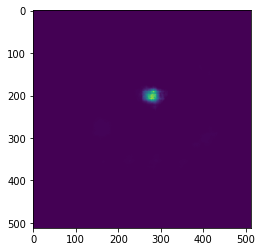

In [126]:
plt.imshow(autoenc.predict(val_maskgen[0])[0])